# Data Access and Cleaning

The purpose of this notebook is to download the subsurface data from the Washington State Department of Natural Resources (DNR) [Geologic Information Portal](https://www.dnr.wa.gov/geologyportal), available for [download](https://www.dnr.wa.gov/programs-and-services/geology/publications-and-data/gis-data-and-databases). 

This data is then filtered to our desired area of interest, clipped to the extent of the study area, and saved as a GeoPackage file.

Finally, the data is loaded for exploratory data analysis.

#### Import libraries

In [1]:
import requests
import zipfile
import os
import pandas as pd
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

____________________

#### Download data

In [2]:
# Define the URL and save path for the zip file
url = 'https://fortress.wa.gov/dnr/geologydata/publications/data_download/ger_portal_subsurface_database.zip'
save_path = '../data/temp/ger_portal_subsurface_database.zip'
extract_path = '../data/temp/extracted_files/'

In [3]:
# Ensure the target folders exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)
os.makedirs(extract_path, exist_ok=True)

In [4]:
try:
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):  # Download in chunks
                file.write(chunk)
    print(f"Downloaded file saved to {save_path}")
except requests.exceptions.RequestException as e:
    print(f"Failed to download the file. Error: {e}")
    exit(1)

Downloaded file saved to ../data/temp/ger_portal_subsurface_database.zip


In [5]:
# Check if the file is a valid ZIP file
if zipfile.is_zipfile(save_path):
    try:
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Files extracted to {extract_path}")
    except zipfile.BadZipFile as e:
        print(f"Error: The file at {save_path} is a bad ZIP file. {str(e)}")
else:
    print(f"Error: The file at {save_path} is not recognized as a valid ZIP file.")

Files extracted to ../data/temp/extracted_files/


____________________

#### Filter and clip data

In [6]:
# View the extracted files
extracted_files = os.listdir(extract_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['layer_files', 'metadata', 'README_subsurface.docx', 'Subsurface_Database.mpkx', 'WGS_Subsurface_Database.gdb']


In [7]:
# Open the geodatabase file: 'WGS_Subsurface_Database.gdb' in the extracted files
gdb_path = os.path.join(extract_path, 'WGS_Subsurface_Database.gdb') 

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)
print(f"Layers in the geodatabase: {layers}")

Layers in the geodatabase: ['bedrock', 'hydrologic', 'layer_comments', 'documents', 'in_situ_test_data', 'borehole_info', 'layer_data', 'lithology_logs', 'water_wells', 'subsurface_documents']


In [8]:
# We are interested in the layer_data layer table
layer_data = gpd.read_file(gdb_path, layer='layer_data')
print(f"Shape of the layer_data table: {layer_data.shape}")

# Display the first few rows of the layer_data table
layer_data.head()

Shape of the layer_data table: (410670, 15)


,BOREHOLE_ID,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,DESCRIPTION,LAYER_TYPE,USCS,SYMBOL_LITHOLOGY,INTERPRETED_LITHOLOGY,GEOLOGIC_UNIT,GEOLOGIC_UNIT_CONFIDENCE,GEOLOGIST,COMMENTS,GlobalID,geometry
0,1,1,0.0,1.2,"Duff and roots over loose, dark brown, silty f...",Single,PT,Fill,Fill,None,None,None,USCS interpretation provided digitally,{C60F4713-9212-4598-8306-4226ACEDC52D},None
1,1,2,1.2,2.7,"Soft, gray-brown, mottled, very fine, sandy si...",Single,ML,Sandy silt,Colluvium,None,None,None,USCS interpretation provided digitally,{6DDD70BC-6B1F-4F63-BB45-72C729669ED3},None
2,1,3,2.7,8.0,"Very stiff to hard, gray-brown, silt with some...",Single,ML,Silt,None,Qvlc,High,"Kathy Troost, UW, log review","At 7.5 ft hard, gray, damp, thinly bedded; USC...",{9F292B80-D7EC-4F5F-9CF1-304FE2BF527A},None
3,2,1,0.0,0.8,"Duff, topsoil and roots, moist",Single,PT,Topsoil / vegetation,Colluvium,None,None,None,USCS interpretation provided digitally,{41FEDF4D-4870-4D87-8875-ABE25C50F0C0},None
4,2,2,0.8,2.5,"Loose, reddish-brown, silty sand, moist to wet",Single,SM,Silty sand,Colluvium,None,None,None,USCS interpretation provided digitally,{779313E0-A006-4263-88E4-16DECF5F8E8E},None


In [9]:
# Only keep the columns of interest
columns_of_interest = ['BOREHOLE_ID', 'LAYER_NUMBER', 'TOP_DEPTH_FT', 'BOTTOM_DEPTH_FT', 'USCS']

# Filter the layer_data table to only include the columns of interest
layer_data_filtered = layer_data[columns_of_interest]

# Display the first few rows of the filtered table
layer_data_filtered.head()

,BOREHOLE_ID,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS
0,1,1,0.0,1.2,PT
1,1,2,1.2,2.7,ML
2,1,3,2.7,8.0,ML
3,2,1,0.0,0.8,PT
4,2,2,0.8,2.5,SM


In [10]:
# Also read the 'borehole_info' table, which contains information about the boreholes such as location, depth, etc.
borehole_info = gpd.read_file(gdb_path, layer='borehole_info')
print(f"Shape of the borehole_info table: {borehole_info.shape}")

# Display the first few rows of the borehole_info table
borehole_info.head()

Shape of the borehole_info table: (100410, 25)


,BOREHOLE_ID,DOCUMENT_ID,BOREHOLE_NAME,BOREHOLE_CLASS,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,BOREHOLE_DIAMETER_IN,BOREHOLE_DATE,ELEVATION_FT,ELEVATION_METHOD,...,DATA_CONFIDENCE,COUNTY_NAME,SOURCE_DB_CODE,SOURCE_DB_ID,COMMENTS,ECYID,REPORTED_ELEVATION,REPORTED_ELEVATION_METHOD,GlobalID,geometry
0,1,342,EP-1,Test pit,Test pit,8.0,NaN,1989-01-19 00:00:00+00:00,148.8,LiDAR,...,None,King,1,31843,None,NaN,137.0,Well log,{25EECC4A-AFA9-412F-A0AE-247A5867271B},POINT (1169694.000 822933.000)
1,2,342,EP-2,Test pit,Test pit,9.0,NaN,1989-01-19 00:00:00+00:00,149.5,LiDAR,...,None,King,1,27464,None,NaN,139.0,Well log,{E3B69C7F-365F-4711-84EA-F713E6C4212D},POINT (1169692.000 822906.000)
2,3,342,EP-3,Test pit,Test pit,6.0,NaN,1989-01-19 00:00:00+00:00,142.2,LiDAR,...,None,King,1,64110,None,NaN,134.0,Well log,{8170263A-E3FA-4185-8BC1-9CDDB5FFD1D9},POINT (1169637.000 822923.000)
3,4,343,EP-1,Test pit,Test pit,13.0,NaN,1986-12-01 00:00:00+00:00,129.8,LiDAR,...,None,King,1,39838,None,NaN,NaN,None,{94808B62-C6CA-491B-B194-6E3775F5A8DE},POINT (1169881.000 823184.000)
4,5,343,EP-2,Test pit,Test pit,13.0,NaN,1986-12-01 00:00:00+00:00,136.2,LiDAR,...,None,King,1,62396,None,NaN,NaN,None,{B6D17DAC-2758-4754-995E-F2095C999FE0},POINT (1169930.000 823178.000)


In [11]:
# Only keep the columns of interest
columns_of_interest = ['BOREHOLE_ID', 'BOREHOLE_NAME', 'BOREHOLE_TYPE', 'BOREHOLE_DEPTH_FT', 'ELEVATION_FT', 'LATITUDE', 'LONGITUDE']

# Filter the borehole_info table to only include the columns of interest
borehole_info_filtered = borehole_info[columns_of_interest]

# Display the first few rows of the filtered table
borehole_info_filtered.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE
0,1,EP-1,Test pit,8.0,148.8,47.574251,-122.407051
1,2,EP-2,Test pit,9.0,149.5,47.574177,-122.407057
2,3,EP-3,Test pit,6.0,142.2,47.574220,-122.407281
3,4,EP-1,Test pit,13.0,129.8,47.574951,-122.406319
4,5,EP-2,Test pit,13.0,136.2,47.574938,-122.406119


In [12]:
# Combine the two tables based on the 'BOREHOLE_ID' column, note that there are multiple layer_data entries for each borehole
borehole_data = pd.merge(borehole_info_filtered, layer_data_filtered, on='BOREHOLE_ID', how='inner')
print(f"Shape of the merged table: {borehole_data.shape}")

# Display the first few rows of the merged table
borehole_data.head()

Shape of the merged table: (341158, 11)


,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS
0,1,EP-1,Test pit,8.0,148.8,47.574251,-122.407051,1,0.0,1.2,PT
1,1,EP-1,Test pit,8.0,148.8,47.574251,-122.407051,2,1.2,2.7,ML
2,1,EP-1,Test pit,8.0,148.8,47.574251,-122.407051,3,2.7,8.0,ML
3,2,EP-2,Test pit,9.0,149.5,47.574177,-122.407057,1,0.0,0.8,PT
4,2,EP-2,Test pit,9.0,149.5,47.574177,-122.407057,2,0.8,2.5,SM


In [13]:
# We are only interested in 'Geotechnical' borehole types
borehole_data = borehole_data[borehole_data['BOREHOLE_TYPE'] == 'Geotechnical']

# Display the first few rows of the filtered table
borehole_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS
20,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,1,0.0,2.5,OH
21,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,2,2.5,3.0,SC
22,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,3,3.0,4.0,SC
23,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,4,4.0,6.5,SC
24,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,5,6.5,7.5,CL-ML


In [14]:
# Drop any rows with "Unknown" or "Not Applicable" values in the 'USCS' column
# borehole_data = borehole_data[(borehole_data['USCS'] != 'Unknown') & ('Not Applicable' not in borehole_data['USCS']) & ('Not applicable' not in borehole_data['USCS']) & ('Now applicable' not in borehole_data['USCS']) & ('Not applicabble' not in borehole_data['USCS']) & ('Not application' not in borehole_data['USCS'])]
# print(f"Shape of the filtered table: {borehole_data.shape}")
# Define the regex pattern to match variations of "Unknown" and "Not Applicable"
pattern = r'Unknown|Not\s*Applicable|Not\s*applicable|Now\s*applicable|Not\s*applicabble|Not\s*application'

# Drop rows where the 'USCS' column contains any of the specified patterns
borehole_data = borehole_data[~borehole_data['USCS'].str.contains(pattern, case=False, na=False)]

# Compute the thickness of each layer
borehole_data['LAYER_THICKNESS_FT'] = borehole_data['BOTTOM_DEPTH_FT'] - borehole_data['TOP_DEPTH_FT']

# Display the first few rows of the table with the thickness column
borehole_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,LAYER_THICKNESS_FT
20,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,1,0.0,2.5,OH,2.5
21,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,2,2.5,3.0,SC,0.5
22,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,3,3.0,4.0,SC,1.0
23,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,4,4.0,6.5,SC,2.5
24,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,5,6.5,7.5,CL-ML,1.0


In [15]:
# Write the final table to a CSV file
output_file = '../data/borehole_data.csv'
borehole_data.to_csv(output_file, index=False)

____________________

#### Exploratory Data Analysis

In [16]:
# In the first iteration of this project, we will only try to predict the USCS and layer thickness of the uppermost soil layer (Layer 1).
# Read in the CSV file
borehole_data = pd.read_csv(output_file)

# Filter the data to only include Layer 1
layer_1_data = borehole_data[borehole_data['LAYER_NUMBER'] == 1]

# Display the first few rows of the filtered table
layer_1_data.head()

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,LAYER_THICKNESS_FT
0,7,EB-1,Geotechnical,41.0,131.3,47.575005,-122.406037,1,0.0,2.5,OH,2.5
11,8,EB-2,Geotechnical,40.0,130.9,47.574982,-122.406239,1,0.0,5.0,SC,5.0
18,15,HB-1,Geotechnical,10.5,46.3,47.512358,-122.394125,1,0.0,7.5,ML,7.5
21,16,HB-2,Geotechnical,6.9,47.7,47.512384,-122.394069,1,0.0,5.0,ML,5.0
23,17,HB-3,Geotechnical,13.5,40.9,47.512208,-122.394083,1,0.0,8.6,ML,8.6


In [17]:
# We are also only interested in a small region around the University of Washington, Seattle, to begin
# Define the bounding box for the region around the University of Washington, Seattle
min_lon, max_lon = -122.318, -122.3
min_lat, max_lat = 47.647, 47.66

# Filter the data to only include the region around the University of Washington, Seattle
uw_layer1_data = layer_1_data[(layer_1_data['LONGITUDE'] >= min_lon) & (layer_1_data['LONGITUDE'] <= max_lon) & (layer_1_data['LATITUDE'] >= min_lat) & (layer_1_data['LATITUDE'] <= max_lat)]

# Display the first few rows of the filtered table
uw_layer1_data

,BOREHOLE_ID,BOREHOLE_NAME,BOREHOLE_TYPE,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,USCS,LAYER_THICKNESS_FT
7777,7138,B-1,Geotechnical,20.3,167.8,47.656719,-122.305728,1,0.0,1.0,SP,1.0
7788,7143,B-1-92,Geotechnical,48.5,123.2,47.653642,-122.306837,1,0.0,1.0,ML,1.0
7792,7144,B-2-92,Geotechnical,42.5,122.9,47.653766,-122.306468,1,0.0,1.0,ML,1.0
7797,7145,B-3-92,Geotechnical,43.0,117.3,47.653256,-122.306638,1,0.0,1.0,ML,1.0
7802,7146,B-4-92,Geotechnical,43.0,123.4,47.653709,-122.306259,1,0.0,0.5,SM,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
83497,143748,GEI-18,Geotechnical,44.0,55.2,47.652565,-122.312491,1,0.0,0.2,GP,0.2
83503,143749,GEI-19,Geotechnical,43.5,33.0,47.652437,-122.312202,1,0.0,0.2,GP,0.2
83511,143750,GEI-20,Geotechnical,40.5,54.5,47.652051,-122.312574,1,0.0,0.2,GP,0.2
83521,143752,GEI-22,Geotechnical,46.0,67.9,47.652673,-122.312571,1,0.0,0.2,GP,0.2


In [18]:
# Layer 1 statistics
uw_layer1_data.describe()

,BOREHOLE_ID,BOREHOLE_DEPTH_FT,ELEVATION_FT,LATITUDE,LONGITUDE,LAYER_NUMBER,TOP_DEPTH_FT,BOTTOM_DEPTH_FT,LAYER_THICKNESS_FT
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.0,252.0,252.000000,252.000000
mean,44366.722222,58.782937,80.441270,47.653005,-122.310294,1.0,0.0,7.742063,7.742063
std,28891.106151,55.070554,46.585931,0.002696,0.003875,0.0,0.0,8.171794,8.171794
min,7138.000000,3.900000,16.700000,47.647830,-122.317996,1.0,0.0,0.200000,0.200000
25%,29188.750000,32.500000,37.875000,47.651112,-122.312516,1.0,0.0,3.000000,3.000000
50%,46937.500000,43.350000,68.300000,47.653240,-122.310950,1.0,0.0,5.000000,5.000000
75%,53677.250000,55.425000,122.950000,47.654733,-122.308026,1.0,0.0,9.625000,9.625000
max,143753.000000,273.500000,187.400000,47.659969,-122.300016,1.0,0.0,43.000000,43.000000


In [19]:
# Display the unique values in the 'USCS' column and their counts
uscs_counts = uw_layer1_data['USCS'].value_counts()
print(uscs_counts)

SM       164
ML        23
GP        15
SP        12
SP-SM      8
PT         5
GM         5
OL         5
SW         4
OH         3
SW-SM      2
SC         2
MH         1
GW         1
CL         1
GP-GM      1
Name: USCS, dtype: int64


<Axes: xlabel='LAYER_THICKNESS_FT', ylabel='Count'>

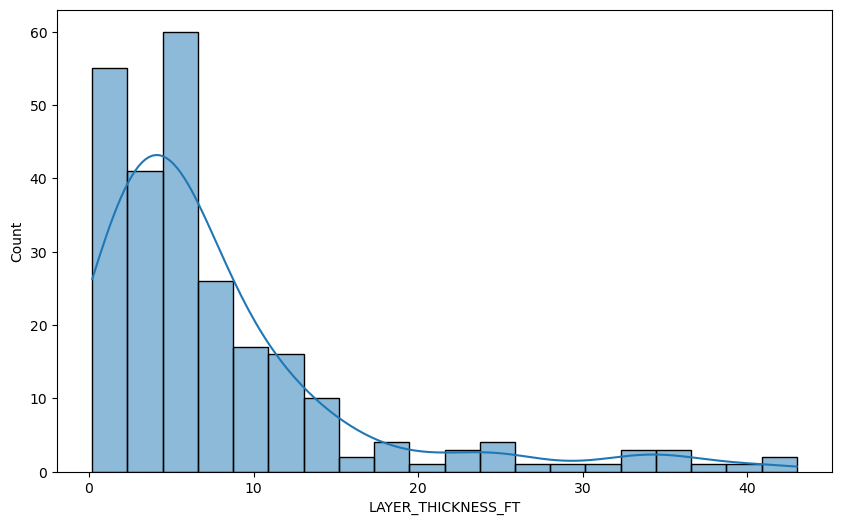

In [20]:
# Make a histogram of the layer thickness values
plt.figure(figsize=(10, 6))
sns.histplot(uw_layer1_data['LAYER_THICKNESS_FT'], bins=20, kde=True)

In [21]:
# Save the filtered data to a new CSV file
output_file = '../data/uw_layer1_data.csv'
uw_layer1_data.to_csv(output_file, index=False)

____________________

Source: 
1. Washington Geological Survey, 2023, Subsurface database--GIS data, July 2023: Washington Geological Survey Digital Data Series 11, version 2.3, previously released March 2023. https://fortress.wa.gov/dnr/geologydata/publications/data_download/ger_portal_subsurface_database.zip
